SYDE 522 Final Project - Kopal Garg, 20657685

Project Title: COVID-19 Tweets Classification



Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_train.csv

In [ ]:
# -- Import libraries --
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import re, string, unicodedata
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Pre-processing 



In [ ]:
# -- Load data --
train = pd.read_csv("/content/drive/MyDrive/SYDE522Project/data/Corona_NLP_train.csv", encoding='L1')
test = pd.read_csv("/content/drive/MyDrive/SYDE522Project/data/Corona_NLP_test.csv", encoding='L1')

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


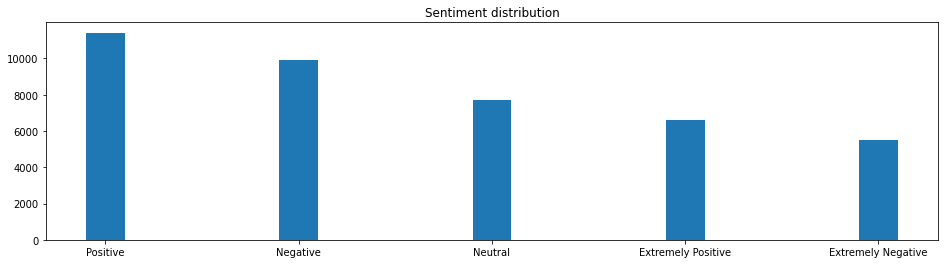

In [ ]:
# -- Data distribution -- 
fig = plt.figure(figsize=(16, 4))

plt.bar(x=train.Sentiment.value_counts().index,
        height=train.Sentiment.value_counts().values,
        width=0.2, 
        align = 'center')

plt.title('Sentiment distribution')

plt.show()

In [ ]:
## -- Remove any rows with NAs in the OriginalTweet and Sentiment columns  --
train.OriginalTweet.dropna()
train.Sentiment.dropna()
test.OriginalTweet.dropna()
test.Sentiment.dropna()

0       Extremely Negative
1                 Positive
2       Extremely Positive
3                 Negative
4                  Neutral
               ...        
3793              Positive
3794              Negative
3795               Neutral
3796    Extremely Negative
3797    Extremely Positive
Name: Sentiment, Length: 3798, dtype: object

In [ ]:
## -- Remove stop-words ('a', 'an', 'the') - Example --
stop_words_english = stopwords.words('english')  

word_tokens = word_tokenize(train['OriginalTweet'][2]) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words_english] 
  
filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words_english: 
        filtered_sentence.append(w.lower()) 
  
print(word_tokens) 
print(filtered_sentence)

## -- Run over all rows --
func = lambda text : " ".join([word for word in str(text).split() if word.lower() not in stop_words_english])
train['OriginalTweet'] = train['OriginalTweet'].apply(func)
test['OriginalTweet'] = test['OriginalTweet'].apply(func)


['Coronavirus', 'Australia', ':', 'Woolworths', 'to', 'give', 'elderly', ',', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID-19', 'outbreak', 'https', ':', '//t.co/bInCA9Vp8P']
['coronavirus', 'australia', ':', 'woolworths', 'give', 'elderly', ',', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid-19', 'outbreak', 'https', ':', '//t.co/binca9vp8p']


In [ ]:
## -- Remove URLs from tweets and conver to lowercase --
for row in range(0,len(train)):
  train['OriginalTweet'][row]= re.sub(r"http\S+", "", train['OriginalTweet'][row]).lower()

for row in range(0,len(test)):
  test['OriginalTweet'][row]= re.sub(r"http\S+", "", test['OriginalTweet'][row]).lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
## -- Convert labels to categorical --
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"

train['Sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))

#train['Sentiment'] = train['Sentiment'].factorize()[0]
#test['Sentiment'] = test['Sentiment'].factorize()[0]

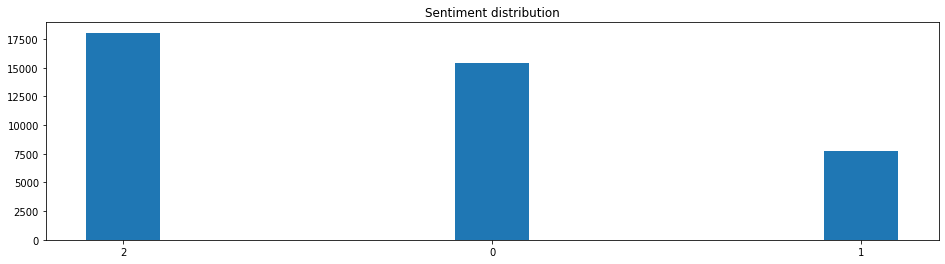

In [ ]:
fig = plt.figure(figsize=(16, 4))

plt.bar(x=train.Sentiment.value_counts().index,
        height=train.Sentiment.value_counts().values,
        width=0.2, 
        align = 'center')

plt.title('Sentiment distribution')

plt.show()

Data transformations

In [ ]:
## -- Convert texts into more managable representations (TF-IDF weighted vectors) --
tfidf = TfidfVectorizer(sublinear_tf = True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(train['OriginalTweet'])
features.shape

(41157, 23350)

Split the training data into training and validation sets

In [ ]:
## -- Split training data into training and validation sets --
X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(features, 
                                                                      train['Sentiment'],
                                                                      test_size= 0.1)

# = test.drop(labels = ["Sentiment"],axis = 1)
#Y_test = test['Sentiment']

Experiment with different supervised multi-class classifiers and evaluate their accuracy

1. Random Forest 
2. Linear SVM
3. Multinomial Naive Bayes


In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=200),
    #SVC(C=100, gamma=0.01, kernel="rbf")
    ]
CV = 5
CV_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
CV_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Plot accuracies 

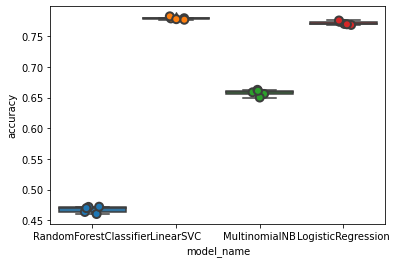

In [ ]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=CV_df)
sns.stripplot(x='model_name', y='accuracy', data=CV_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
CV_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.779218
LogisticRegression        0.771523
MultinomialNB             0.657812
RandomForestClassifier    0.467725
Name: accuracy, dtype: float64

Based on the accuracies, I see that Linear SVC performs the best. I will further evaluate the performace of this model.

In [ ]:
model = LinearSVC()

model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)

c_matrix = confusion_matrix(Y_valid, Y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(c_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: ignored

In [ ]:
print(metrics.classification_report(Y_valid, Y_pred, 
                                    target_names= Y_train.unique()))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1546
           2       0.68      0.63      0.66       772
           1       0.82      0.82      0.82      1798

    accuracy                           0.78      4116
   macro avg       0.76      0.76      0.76      4116
weighted avg       0.78      0.78      0.78      4116

